In [1]:
%pylab inline
import scipy

from pyiga import bspline, assemble, geometry, vis

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)

def linelast_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx
    vf = VForm(dim)
    u, v = vf.basisfuns(components=(dim,dim)) # vector valued
    #vf.add(2* Mu *inner(1/2 * (grad(u) + grad(u).T), 1/2 * (grad(v) + grad(v).T)) * dx + Lam * div(u) * div(v)  * dx)
    e_u = 1/2 * (grad(u) + grad(u).T)
    e_v =  1/2 * (grad(v) + grad(v).T)
    vf.add(2* Mu *inner(e_u, e_v) * dx + Lam * div(u) * div(v)  * dx) 
    return vf


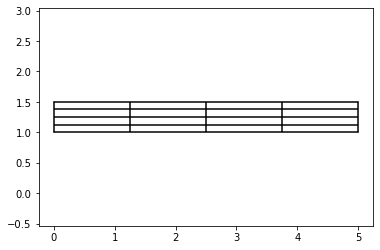

In [3]:
# undeformed stick
geo = geometry.tensor_product(geometry.line_segment(1,1.5), geometry.line_segment(0,5, intervals=3))

vis.plot_geo(geo, grid=5)
axis('equal');

In [4]:
# define geometry
#geo = geometry.quarter_annulus()

# define discretization space
p =3  # spline degree of velocity space #p=3
#n_el = (50, 20)   # number of elements in y/x direction
n_el = (50, 10) # istotropic material

# displacement space: degree p,   continuity p-2
kvs_u = tuple(bspline.make_knots(p,  0.0, 1.0, n, mult=1) for n in n_el)
m_u = tuple(kv.numdofs for kv in kvs_u)

A = assemble.assemble_vf(linelast_vf(2), kvs_u, geo=geo, symmetric=True)
print(shape(A))

Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod836f42f5ef7b3fb9.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod836f42f5ef7b3fb9.pyx
(1378, 1378)


In [5]:
# define Dirichlet boundary conditions
def g_def(x, y):  return (0.0, (1-y)*(1.5-y)) # at boundary = 0 , only in 2nd component
def g_zero(x, y): return (0.0, 0.0)

# set Dirichlet condition
bcs = assemble.compute_dirichlet_bcs(kvs_u, geo,
        [('left', g_zero)]) # left: dirichlet boundary cond.


In [6]:
# set inhom. Neumann cond. on distal end, hom. NBC elsewhere
#def g(x, y): return (0,-3e-7) # Neumann BC function
def g0(x,y):
    if (x>4).all():
        return -3e-7 # set force at distal end only
    else:
        return 0
    
def g(x,y):
    if isinstance(x,numpy.float64):
        return (0,g0(x,y))
    return (0,[g0(xi,0) for xi in np.nditer(x)])


# assemble neumann condition
gn= assemble.assemble('inner(g,v)*ds', kvs_u, bfuns=[('v',2)], geo=geo, g=g, boundary='top')
g2= assemble.boundary_dofs(kvs_u,'top',ravel=True) # gives us all boundary dofs

# incorporate neumnann boundary condition
shape_a= shape(A)[0]

nbc= np.zeros(shape(A)[0])
for i in range(len(g2)):
    nbc[g2[i]]= gn[0,0,i] #gn[0,i,0],gn[0,0,i] X-component
    nbc[g2[i]+shape_a//2]= gn[1,0,i] #gn[1,i,0], gn[1,0,i] Y component


In [7]:
f = lambda x,y: (0,0)  # source term
rhs = assemble.inner_products(kvs_u, f, f_physical=True, geo=geo).ravel()

In [8]:
# solve system with the given boundary conditions and 0 right-hand side
LS = assemble.RestrictedLinearSystem(A, nbc+rhs, bcs)
u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
u = LS.complete(u)
print(u)


[ 0.         -0.00087726 -0.00249344 ... -0.14054389 -0.15612504
 -0.16391028]


In [ ]:
#split the solution into its components (displacement in x- and y- direction)
N = np.prod(tuple(kv.numdofs for kv in kvs_u))
u1 = u[:N].reshape(m_u)
u2 = u[N:2*N].reshape(m_u)
U = np.stack((u1,u2), axis=-1)

displ = geometry.BSplineFunc(kvs_u, U) 

In [ ]:
# evaluate displacement over a grid in the parameter domain
xgrid = linspace(0, 1, 20)
xygrid = (xgrid, xgrid)

G = geo.grid_eval(xygrid)
dis = displ.grid_eval(xygrid)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()


In [ ]:
# plot deformation
#plt.subplot(226)
figsize(10,10)
fig, ax = plt.subplots()

plot_grid(G[...,0], G[...,1], ax=ax, color="lightgrey")
plot_grid(G[...,0]+dis[...,0], G[...,1]+dis[...,1], ax=ax, color="black")

# colormesh w.r.t. displacement & deformed geometry
pcolormesh(G[...,0]+dis[...,0], G[...,1]+dis[...,1], dis[...,1], cmap='summer', shading='gouraud');
colorbar();

axis('equal');

In [ ]:
y_val=[]
for i in range(len(dis)):
    y_val = np.append(y_val,dis[0,i,1])

fig, ax = plt.subplots()
ax.set_ylabel('Deformation')
ax.set_xlabel('Evaluation points on grid')
  
ax.set_xlim(0, len(xgrid))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(y_val)
ax.plot(y_val, color='g', label='p3')

plt.show()
